# JaxMARL Example Usage

Welcome to a walkthrough of the JaxMARL repo. We include several popular MARL environemnts and algorithms, allowing you to easily evaluate your new approach! This colab will showcase our API, the speed of our environments and how to train over multiple seeds.

⚠️ Ensure you select a GPU from `Runtime > Change runtime type` ⚠️

### Install dependencies 📚

We install JAX for use with a GPU, there is rather a lot to download so this may take a second or two.

Note, that the runtime will reboot automatically immediately after.


In [6]:
!pip3 install --upgrade -qq "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip3 install -qq matplotlib jaxmarl pettingzoo
exit(0) #essentially, restarts the runtime after the installation

# if mistake, perhaps you have another version of Python, run then instead
# !pip install --upgrade -qq "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install -qq matplotlib jaxmarl pettingzoo
# exit(0) #essentially, restarts the runtime after the installation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxmarl 0.1.0 requires jax<=0.4.38, but you have jax 0.6.1 which is incompatible.


## Part 1: JaxMARL API 🕹️

Our API is inspired by [PettingZoo](https://github.com/Farama-Foundation/PettingZoo) and [Gymnax](https://github.com/RobertTLange/gymnax), making it familiar to MARL researchers. Below, an MPE scenario is instatiated from JaxMARL's registry and a trajectory is sampled using random actions. We then visualise the results. Examples for more JaxMARL environments can be found [here](https://github.com/FLAIROx/JaxMARL/tree/main/jaxmarl/tutorials).

* `actions`, `obs`, `rewards`, `dones` are dictionaries keyed by agent name, this allows for differing action and observation spaces. As agents can terminate asychronously, `dones` contains a special `"__all__"` which signifies whether an episode has terminated.
* `state` represents the internal state of the environment and contains all the information needed to transistion the environment given a set of actions. These variables are not held within the environment class due to JAX transformations requiring pure functions.
* `info` is a dictionary containing pertinent information, the exact content varies environment to environment.


list of agents in environment ['agent_0', 'agent_1']
example action dict {'agent_0': Array(40, dtype=int32), 'agent_1': Array(37, dtype=int32)}
Comm active?  True
comm idx [0 1]


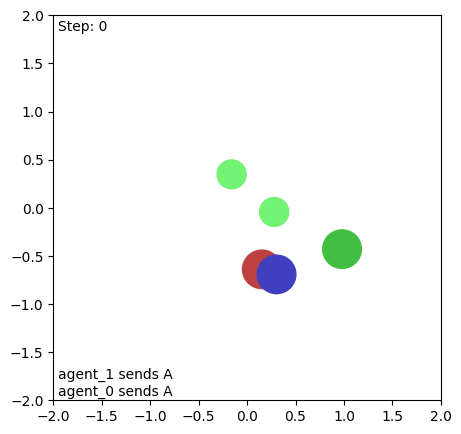

In [2]:
%matplotlib inline

import matplotlib.animation as animation
import jax
from jaxmarl import make
from jaxmarl.environments.mpe import MPEVisualizer

# Parameters + random keys
max_steps = 25
key = jax.random.PRNGKey(0)
key, key_r, key_a = jax.random.split(key, 3)

# Instantiate environment
env = make('MPE_simple_reference_v3')
obs, state = env.reset(key_r)
print('list of agents in environment', env.agents)

# Sample random actions
key_a = jax.random.split(key_a, env.num_agents)
actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}
print('example action dict', actions)

# Collect trajectory
state_seq = []
for _ in range(max_steps):
    state_seq.append(state)
    # Iterate random keys and sample actions
    key, key_s, key_a = jax.random.split(key, 3)
    key_a = jax.random.split(key_a, env.num_agents)
    actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}

    # Step environment
    obs, state, rewards, dones, infos = env.step(key_s, state, actions)

# Visualise
viz = MPEVisualizer(env, state_seq)
ani = animation.FuncAnimation(
    viz.fig,
    viz.update,
    frames=len(viz.state_seq),
    blit=False,
    interval=viz.interval,
)

from IPython.display import HTML
HTML(ani.to_html5_video())

## Part 2: Compare speed 🚀

We can then compare the speed of JaxMARL's MPE environments to the CPU-based ones provided by PettingZoo. We again take random actions and compare the number of environment steps per second between the two implementations.

We also show how JaxMARL environments can be simply vectorised, using `jax.vmap`, to greatly increase the number of environment steps per second.

In [1]:
MPE_ENV = "MPE_simple_reference_v3"

In [3]:
import numpy as np
import jaxmarl
import jax

def make_benchmark(config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]

    def benchmark(rng):
        def init_runner_state(rng):

            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (env_state, obsv, rng)

        def env_step(runner_state, unused):
            env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)
            rngs = jax.random.split(_rng, config["NUM_ACTORS"]).reshape((env.num_agents, config["NUM_ENVS"], -1))
            actions = {k: jax.vmap(env.action_space(k).sample)(rngs[i]) for i, k in enumerate(env.agents)}

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, actions
            )
            runner_state = (env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark

In [4]:
import time
import jax
import jax.numpy as jnp
from jaxmarl.environments.mpe.simple_world_comm import SimpleWorldCommMPE
from pettingzoo.mpe import simple_v3, simple_tag_v3, simple_world_comm_v3, simple_reference_v3, simple_spread_v3, simple_crypto_v3, simple_speaker_listener_v4, simple_push_v3, simple_adversary_v3

from mpe2 import (
    simple_v3, simple_tag_v3, simple_world_comm_v3, simple_reference_v3,
    simple_spread_v3, simple_crypto_v3, simple_speaker_listener_v4,
    simple_push_v3, simple_adversary_v3,
)


import time

config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 1000,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": MPE_ENV,
    "NUM_SEEDS": 1,
    "SEED": 0,
}

### JAXMARL BENCHMARK
num_envs = [1, 100, 1000, 10000]
jaxmarl_sps = []
for num in num_envs:
  config["NUM_ENVS"] = num
  benchmark_fn = jax.jit(make_benchmark(config))
  rng = jax.random.PRNGKey(config["SEED"])
  rng, _rng = jax.random.split(rng)
  benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
  before = time.perf_counter_ns()
  runner_state = jax.block_until_ready(benchmark_jit(_rng))
  after = time.perf_counter_ns()
  total_time = (after - before) / 1e9

  sps = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time
  jaxmarl_sps.append(sps)

  print(f"JaxMARL, Num Envs: {num}, Total Time (s): {total_time}")
  print(f"JaxMARL, Num Envs: {num}, Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
  print(f"JaxMARL, Num Envs: {num}, SPS: {sps}")


### PETTING ZOO BENCHMARK
zoo_mpe_env_mapper = {
    "MPE_simple_v3": simple_v3,
    "MPE_simple_world_comm_v3": simple_world_comm_v3,
    "MPE_simple_tag_v3": simple_tag_v3,
    "MPE_simple_spread_v3": simple_spread_v3,
    "MPE_simple_crypto_v3": simple_crypto_v3,
    "MPE_simple_speaker_listener_v4": simple_speaker_listener_v4,
    "MPE_simple_push_v3": simple_push_v3,
    "MPE_simple_adversary_v3": simple_adversary_v3,
    "MPE_simple_reference_v3": simple_reference_v3,
}
zoo_env = zoo_mpe_env_mapper[config["ENV_NAME"]]
env = zoo_env.parallel_env(max_cycles=max_steps)
obs = env.reset()

start_time = time.time()
actions = {agent: env.action_space(agent).sample() for agent in env.agents}

for _ in range(config["NUM_STEPS"]):
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}  # this is where you would insert your policy
    observations, rewards, terminations, truncations, infos = env.step(actions)

zoo_time = time.time() - start_time
zoo_sps = config["NUM_STEPS"]/zoo_time


print(f"PettingZoo Total Time (s): {zoo_time}")
print(f"PettingZoo Total Steps: {config['NUM_STEPS']}")
print(f"PettingZoo SPS: {zoo_sps}")


/var/folders/j9/p_wvjz5d10v3yjq250r7pzl00000gn/T/ipykernel_24186/170463258.py:5: DeprecationWarning: The environment `pettingzoo.mpe` has been moved to `mpe2` and will be removed in a future release.Please update your imports.
  from pettingzoo.mpe import simple_v3, simple_tag_v3, simple_world_comm_v3, simple_reference_v3, simple_spread_v3, simple_crypto_v3, simple_speaker_listener_v4, simple_push_v3, simple_adversary_v3


JaxMARL, Num Envs: 1, Total Time (s): 0.019589959
JaxMARL, Num Envs: 1, Total Steps: 1000
JaxMARL, Num Envs: 1, SPS: 51046.55910714259
JaxMARL, Num Envs: 100, Total Time (s): 0.213726083
JaxMARL, Num Envs: 100, Total Steps: 100000
JaxMARL, Num Envs: 100, SPS: 467888.61048840726
JaxMARL, Num Envs: 1000, Total Time (s): 1.754900833
JaxMARL, Num Envs: 1000, Total Steps: 1000000
JaxMARL, Num Envs: 1000, SPS: 569832.7684365513
JaxMARL, Num Envs: 10000, Total Time (s): 8.03556675
JaxMARL, Num Envs: 10000, Total Steps: 10000000
JaxMARL, Num Envs: 10000, SPS: 1244467.2928639415
PettingZoo Total Time (s): 0.0037870407104492188
PettingZoo Total Steps: 1000
PettingZoo SPS: 264058.42357088893


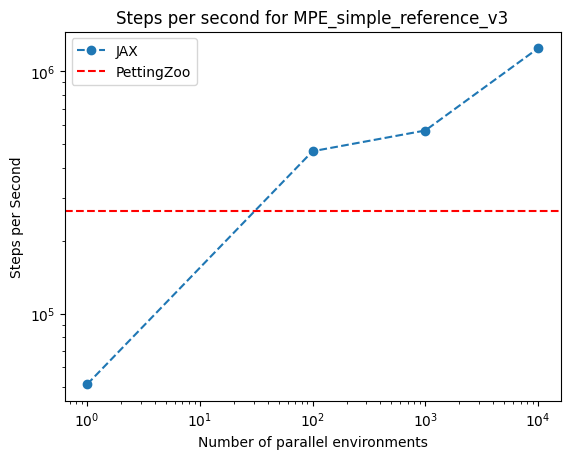

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(num_envs, jaxmarl_sps, linestyle='--', marker='o', label="JAX")
plt.axhline(y=zoo_sps, color='r', linestyle='--', label="PettingZoo")
plt.legend()

plt.ylabel("Steps per Second")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parallel environments")
plt.title(f"Steps per second for {MPE_ENV}")
plt.show()

## Part 3: Train an agent 🍲

We train an agent on the `cramped_room` Overcooked scenario using IPPO, our IPPO code is based off [PureJaxRL](https://github.com/luchris429/purejaxrl). Here we also show how `jax.vmap` can again be used to simply train over multiple seeds.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


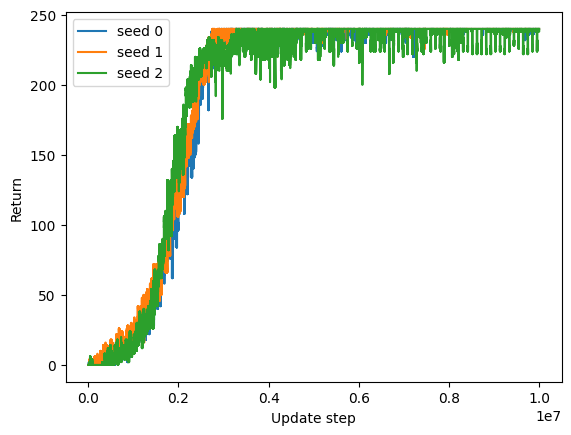

In [25]:
# ============================  IMPORTS  =====================================
import jax, jax.numpy as jnp
import flax.linen as nn
import numpy as np, optax, distrax, matplotlib.pyplot as plt
from flax.training.train_state import TrainState
from flax.linen.initializers import orthogonal, constant
from typing import NamedTuple

import jaxmarl
from jaxmarl.wrappers.baselines import LogWrapper
from jaxmarl.environments.overcooked import overcooked_layouts
# ============================================================================


# ============================  NETWORK  =====================================
class ActorCritic(nn.Module):
    action_dim: int
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        act = nn.relu if self.activation == "relu" else nn.tanh

        # ----- ACTOR -------------------------------------------------------
        y = act(nn.Dense(64,
                         kernel_init=orthogonal(np.sqrt(2)),
                         bias_init=constant(0.0))(x))
        y = act(nn.Dense(64,
                         kernel_init=orthogonal(np.sqrt(2)),
                         bias_init=constant(0.0))(y))
        logits = nn.Dense(self.action_dim,
                          kernel_init=orthogonal(0.01),
                          bias_init=constant(0.0))(y)
        pi = distrax.Categorical(logits=logits)

        # ----- CRITIC ------------------------------------------------------
        z = act(nn.Dense(64,
                         kernel_init=orthogonal(np.sqrt(2)),
                         bias_init=constant(0.0))(x))
        z = act(nn.Dense(64,
                         kernel_init=orthogonal(np.sqrt(2)),
                         bias_init=constant(0.0))(z))
        v = nn.Dense(1,
                     kernel_init=orthogonal(1.0),
                     bias_init=constant(0.0))(z)

        return pi, jnp.squeeze(v, -1)
# ============================================================================


# ======================  ROLLOUT CONTAINER  =================================
class Transition(NamedTuple):
    done:      jnp.ndarray
    action:    jnp.ndarray
    value:     jnp.ndarray
    reward:    jnp.ndarray
    log_prob:  jnp.ndarray
    obs:       jnp.ndarray
    info:      dict
# ============================================================================


# ============================  HELPERS  =====================================
def batchify(dct, agents, n_actors):
    return jnp.stack([dct[a] for a in agents]).reshape((n_actors, -1))

def unbatchify(arr, agents, n_envs, n_agents):
    arr = arr.reshape((n_agents, n_envs, -1))
    return {a: arr[i] for i, a in enumerate(agents)}

def broadcast_info(info, n_envs, n_agents):
    return jax.tree_util.tree_map(
        lambda x: jnp.repeat(x, n_agents, 0).reshape(n_envs * n_agents, *x.shape[1:]),
        info,
    )
# ============================================================================


# ====================  TRAINING FUNCTION FACTORY  ============================
def make_train(cfg):

    env = LogWrapper(jaxmarl.make(cfg["ENV_NAME"], **cfg["ENV_KWARGS"]))

    cfg["NUM_ACTORS"]  = env.num_agents * cfg["NUM_ENVS"]
    cfg["NUM_UPDATES"] = (cfg["TOTAL_TIMESTEPS"] //
                          cfg["NUM_STEPS"]      //
                          cfg["NUM_ENVS"])
    cfg["MINIBATCH_SIZE"] = (cfg["NUM_ACTORS"] * cfg["NUM_STEPS"] //
                             cfg["NUM_MINIBATCHES"])

    def lr_schedule(step):
        frac = 1.0 - (step //
                      (cfg["NUM_MINIBATCHES"] * cfg["UPDATE_EPOCHS"])
                     ) / cfg["NUM_UPDATES"]
        return cfg["LR"] * frac

    # ------------------------------------------------------------------------
    def train(rng):
        # network + optimiser -----------------------------------------------
        net  = ActorCritic(env.action_space("agent_0").n,
                           activation=cfg["ACTIVATION"])
        rng, key = jax.random.split(rng)
        dummy = jnp.zeros(env.observation_space("agent_0").shape).flatten()
        params = net.init(key, dummy)
        tx = optax.chain(optax.clip_by_global_norm(cfg["MAX_GRAD_NORM"]),
                         optax.adam(lr_schedule if cfg["ANNEAL_LR"]
                                    else cfg["LR"], eps=1e-5))
        state = TrainState.create(apply_fn=net.apply, params=params, tx=tx)

        # reset envs --------------------------------------------------------
        rng, key = jax.random.split(rng)
        obs, env_state = jax.vmap(env.reset)(jax.random.split(key, cfg["NUM_ENVS"]))

        # --------------------------------------------------------------------
        def _update_step(step_state, _):
            state, env_state, last_obs, rng = step_state

            # ---------- collect trajectory ---------------------------------
            def _env_step(carry, _):
                env_state, last_obs, rng = carry

                obs_b = batchify(last_obs, env.agents, cfg["NUM_ACTORS"])
                pi, val = net.apply(state.params, obs_b)
                rng, key = jax.random.split(rng)
                action = pi.sample(seed=key)
                logp   = pi.log_prob(action)

                act_dict = {k: v.flatten()
                            for k, v in unbatchify(action, env.agents,
                                                   cfg["NUM_ENVS"], env.num_agents).items()}

                rng, key = jax.random.split(rng)
                step_keys = jax.random.split(key, cfg["NUM_ENVS"])
                obs, env_state2, rew, done, info = jax.vmap(env.step)(
                    step_keys, env_state, act_dict
                )

                info_b = broadcast_info(info, cfg["NUM_ENVS"], env.num_agents)

                tr = Transition(
                    done   = batchify(done, env.agents, cfg["NUM_ACTORS"]).squeeze(),
                    action = action,
                    value  = val,
                    reward = batchify(rew,  env.agents, cfg["NUM_ACTORS"]).squeeze(),
                    log_prob = logp,
                    obs   = obs_b,
                    info  = info_b,
                )
                return (env_state2, obs, rng), tr

            (env_state, last_obs, rng), traj = jax.lax.scan(
                _env_step, (env_state, obs, rng), None, cfg["NUM_STEPS"]
            )

            # ---------- advantages & targets -------------------------------
            obs_b = batchify(last_obs, env.agents, cfg["NUM_ACTORS"])
            _, last_val = net.apply(state.params, obs_b)

            def _gae(traj, last_val):
                def body(carry, t):
                    gae, next_val = carry
                    delta = t.reward + cfg["GAMMA"]*next_val*(1-t.done) - t.value
                    gae   = delta + cfg["GAMMA"]*cfg["GAE_LAMBDA"]*(1-t.done)*gae
                    return (gae, t.value), gae
                (_, _), adv = jax.lax.scan(body,
                                           (jnp.zeros_like(last_val), last_val),
                                           traj, reverse=True, unroll=16)
                return adv, adv + traj.value

            adv, tgt = _gae(traj, last_val)

            # ---------- PPO update ----------------------------------------
            def _epoch(carry, _):
                ts, traj, adv, tgt, rng = carry
                bs = cfg["NUM_STEPS"] * cfg["NUM_ACTORS"]

                traj_core = traj._replace(info=None)        # drop info
                flat = (traj_core, adv, tgt)
                flat = jax.tree_util.tree_map(lambda x: x.reshape((bs,)+x.shape[2:]), flat)

                rng, key = jax.random.split(rng)
                perm = jax.random.permutation(key, bs)
                flat = jax.tree_util.tree_map(lambda x: jnp.take(x, perm, 0), flat)

                mb = jax.tree_util.tree_map(
                    lambda x: x.reshape((cfg["NUM_MINIBATCHES"], -1)+x.shape[1:]), flat)

                def _update(ts, mbatch):
                    tr, adv_mb, tgt_mb = mbatch

                    def loss_fn(p):
                        pi, v = net.apply(p, tr.obs)
                        logp  = pi.log_prob(tr.action)

                        ratio = jnp.exp(logp - tr.log_prob)
                        adv_n = (adv_mb - adv_mb.mean()) / (adv_mb.std()+1e-8)
                        pg = -jnp.minimum(ratio*adv_n,
                                          jnp.clip(ratio,
                                                   1-cfg["CLIP_EPS"],
                                                   1+cfg["CLIP_EPS"]) * adv_n).mean()

                        v_clip = tr.value + (v-tr.value).clip(-cfg["CLIP_EPS"],
                                                              cfg["CLIP_EPS"])
                        v_loss = 0.5 * jnp.maximum(jnp.square(v-tgt_mb),
                                                   jnp.square(v_clip-tgt_mb)).mean()

                        ent = pi.entropy().mean()
                        return pg + cfg["VF_COEF"]*v_loss - cfg["ENT_COEF"]*ent

                    grads = jax.grad(loss_fn)(ts.params)
                    return ts.apply_gradients(grads=grads), None

                ts, _ = jax.lax.scan(_update, ts, mb)
                return (ts, traj, adv, tgt, rng), None

            (state, traj, adv, tgt, rng), _ = jax.lax.scan(
                _epoch, (state, traj, adv, tgt, rng), None, cfg["UPDATE_EPOCHS"]
            )

            return (state, env_state, last_obs, rng), traj.info

        # run all updates ----------------------------------------------------
        rng, key = jax.random.split(rng)
        (_, _, _, _), metrics = jax.lax.scan(
            _update_step, (state, env_state, obs, key),
            None, cfg["NUM_UPDATES"]
        )

        return metrics

    return train
# ============================================================================


# ==============================  CONFIG  =====================================
config = dict(
    LR=2.5e-4,
    NUM_ENVS=16,
    NUM_STEPS=128,
    TOTAL_TIMESTEPS=5_000_000,
    UPDATE_EPOCHS=4,
    NUM_MINIBATCHES=4,
    GAMMA=0.99,
    GAE_LAMBDA=0.95,
    CLIP_EPS=0.2,
    ENT_COEF=0.01,
    VF_COEF=0.5,
    MAX_GRAD_NORM=0.5,
    ACTIVATION="tanh",
    ENV_NAME="overcooked",
    ENV_KWARGS=dict(layout=overcooked_layouts["cramped_room"]),
    ANNEAL_LR=True,
    SEED=0,
    NUM_SEEDS=3,
)
# ============================================================================


# ==============================  RUN  ========================================
def moving_average(arr, k: int = 20):
    arr = jnp.asarray(arr).ravel()          # ensure 1-D for jnp.convolve
    kernel = jnp.ones(k) / k
    return jnp.convolve(arr, kernel, mode="valid")

if __name__ == "__main__":
    rng = jax.random.PRNGKey(config["SEED"])
    rngs = jax.random.split(rng, config["NUM_SEEDS"])

    with jax.disable_jit(False):
        train_vec = jax.jit(jax.vmap(make_train(config)))
        metrics = train_vec(rngs)   # shape (seeds, updates, envs)

    returns = metrics["returned_episode_returns"]  # (S, U, E)

    for s in range(config["NUM_SEEDS"]):
        curve = returns[s].mean(-1)                # average over envs
        plt.plot(moving_average(curve), label=f"seed {s}")

    plt.xlabel("Update step")
    plt.ylabel("Return")
    plt.legend()
    plt.show()
